# Basic recommender system

This is an example of a basic recommender system.

Load the required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import html
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

Define some functions for use later in the code:

In [2]:
# apply a text cleaning function to column reviewText
def clean(text):
    # convert html escapes to characters
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text in code or brackets
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of whitespaces
    text = re.sub(r'\s+', ' ', text)
    # make lower case
    text = text.lower()
    
    return text.strip()

# define the recommender system process
def get_recommendations(title, cosine_sim, indices):
        global res
        # Get the index of the movie that matches the title
        idx = indices[t]
        # Get the pairwsie similarity scores
        sim_scores = list(enumerate(cosine_sim[idx]))
        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores for 10 most similar movies
        sim_scores = sim_scores[0:11]
        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]
        # Return the top 10 most similar movies
        res = data['reviewText'].iloc[movie_indices]
        # make dataframe
        res = res.to_frame().reset_index()
        # get similarity scores
        dff = pd.DataFrame(sim_scores)
        dff.rename(columns={0:'index',1:'similarity'}, inplace=True)
        # combine dataframes
        res = pd.concat([res,dff], axis=1, ignore_index=True)
        res.rename(columns={0:'index',1:'reviewText',2:'index1',3:'similarity'}, inplace=True)
        res = res[['reviewText', 'similarity']]
        return res
    
def bar_graph(x,y,xlabel,ylabel,title):
    fig, ax = plt.subplots()
    
    ax.barh(df_to_use[x],df_to_use[y])

    # Customise some display properties for line graph
    ax.set_ylabel(xlabel,size=8)
    ax.set_xlabel(ylabel,size=8)
    ax.set_title(title,size=9)
    #ax.set_xticklabels(df_to_use[x], rotation=90,size=8)
    #ax.legend(loc='upper left',fontsize=8)
    #ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1])
    ax.set_axisbelow(True) # to put gridlines at back
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
def six_bar_graph(x,y,xlabel,ylabel,title):
    
    fig, ax = plt.subplots(3,2,sharex=True,sharey=False,squeeze=True)
    
    # loop through each ax
    for i, ax in enumerate(ax.flat):
        color_to_use=np.random.rand(len(df_to_use[df_to_use['cluster']==i]),3)

        try:
            ax.barh(df_to_use[x][df_to_use['cluster']==i],df_to_use[y][df_to_use['cluster']==i], color=color_to_use[0])
            
            ax.set_title(df_to_use[x][df_to_use['cluster']==i].iloc[0]+" "+df_to_use[x][df_to_use['cluster']==i].iloc[1]+" "+df_to_use[x][df_to_use['cluster']==i].iloc[2],size=9)
            ax.set_axisbelow(True) # to put gridlines at back
            ax.grid(linestyle='--',color='#CECECE')
            ax.tick_params(axis='y',labelsize=8)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        except:
            pass
    
    plt.show()

Load the data and process, vectorise it

In [3]:
data = pd.read_json("C:\\Users\\kelvi\\Desktop\\reviews_Musical_Instruments_5.json.gz", lines=True)

# select the relevant categories for text and how we want to try and train NLP ml
data = data[['reviewText', 'overall']]

# clean the text data
data['reviewText'] = data['reviewText'].apply(clean)

# get indices
indices = pd.Series(data.index, index=data['reviewText']).drop_duplicates()

movie_plots = data['reviewText']

# use tf-idf vectoriser
tfidf = CountVectorizer(stop_words='english')#, max_features = 300) # irrespective of word occurences
#tfidf = TfidfVectorizer(stop_words='english') # weight given to word occurences

# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(movie_plots)

# get unique list of words
words = tfidf.get_feature_names_out()

# to save space, we can dimensionally reduce the matrix
np.random.seed(0)
shrunk_matrix = TruncatedSVD(n_components=100).fit_transform(tfidf_matrix)

# normalise the SVD output
shrunk_norm_matrix = normalize(shrunk_matrix)

# save vectoriser
#joblib.dump(tfidf_matrix,"vec.pkl")

# load vectoriser
#tfidf_matrix = joblib.load("vec.pkl")

# Generate the cosine similarity matrix - linear_kernel or cosine_similarity
#cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) 
#cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix) 

# cosine sim of shrunk matrix
cosine_sim = shrunk_norm_matrix @ shrunk_norm_matrix.T

# save cosine sim
#joblib.dump(cosine_sim, "sim_matrix.pkl")

# load cosine sim
#cosine_sim = joblib.load("sim_matrix.pkl")

Next, create some phrase to use to search for in the reviews and then get top 10 reviews that are similar to this returned review

In [4]:
chkr = "great guitar" # the phrase to search for
chk = len(chkr)

t = data['reviewText'].str.contains(chkr) # find if reviews contain this phrase - TRUE/FALSE
t = t.to_frame() # make it a dataframe
t = t[t['reviewText']==True] # filter to only those that are TRUE
t = t.index[0] # return/keep only the first TRUE result

# Generate recommendations
print(" linked to: "+chkr)
print(get_recommendations(chkr, cosine_sim, indices))

 linked to: great guitar
                                           reviewText  similarity
0   strings are not just strings. guitar strings a...    1.000000
1   not very substantial. it began to tear on my g...    0.879715
2   i bought a guitar and for a while used the str...    0.869009
3   these strings are beyond amazing. switching to...    0.857657
4   i'm primarily a guitar player, but i do have a...    0.853160
5   these strings are a little more money than the...    0.849725
6   i tried these strings on my zager guitar. the ...    0.840344
7   sturdy, well-designed and frets the strings we...    0.837488
8   these are the best guitar strings i have used ...    0.826279
9   i am yet another one of those "forever beginne...    0.820800
10  these are great guitar strings and are all tha...    0.820313


# what about clustering?
We can cluster the data into topics by using K-Means

In [5]:
from sklearn.cluster import KMeans

cluster_number = 20

# cluster configuration
np.random.seed(0)
cluster_model = KMeans(n_clusters=cluster_number, n_init=10)
clusters = cluster_model.fit_predict(shrunk_norm_matrix)
df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters})

# get sum of cluster sizes
clust = df.groupby(['Cluster']).count().reset_index()
print(clust)

# isolate first cluster
df_rev = df[df.Cluster == clusters[0]]
cluster_size = df_rev.shape[0]
print(f"{cluster_size} reviews cluster together with the reviews "
       "at index 0")

# rank top 10 words in this particular cluster
def rank_words_by_tfidf(indices, word_list=words):
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    data = {'Word': word_list,
            'Summed TFIDF': summed_tfidf}
    return pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)
 
df_ranked_words = rank_words_by_tfidf(df_rev.index)
print(df_ranked_words[:10].to_string(index=False))




    Cluster  Index
0         0    568
1         1    533
2         2    570
3         3    566
4         4    329
5         5    669
6         6    362
7         7    512
8         8    980
9         9    894
10       10    429
11       11    371
12       12    436
13       13    386
14       14    552
15       15    283
16       16    485
17       17    204
18       18    362
19       19    770
362 reviews cluster together with the reviews at index 0
  Word  Summed TFIDF
  does           477
   job           153
  good            98
   use            95
guitar            90
  just            81
 works            73
 great            72
little            71
 price            65


# Visualise the clusters
We can visualise the clusters using matplotlib or wordcloud (e.g. view 5 clusters)

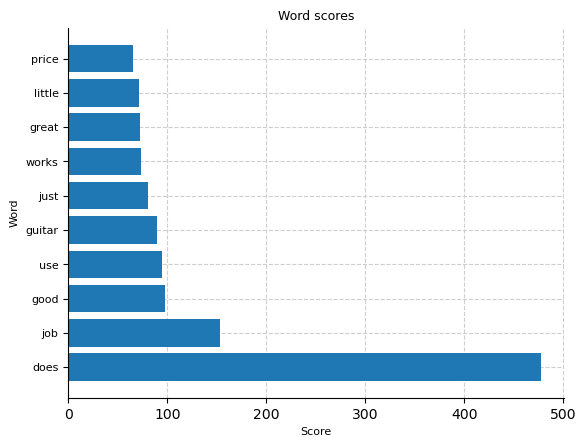

In [6]:
# view top 10 words for a single cluster
df_to_use = df_ranked_words[:10] # top 10
bar_graph('Word','Summed TFIDF','Word','Score','Word scores')

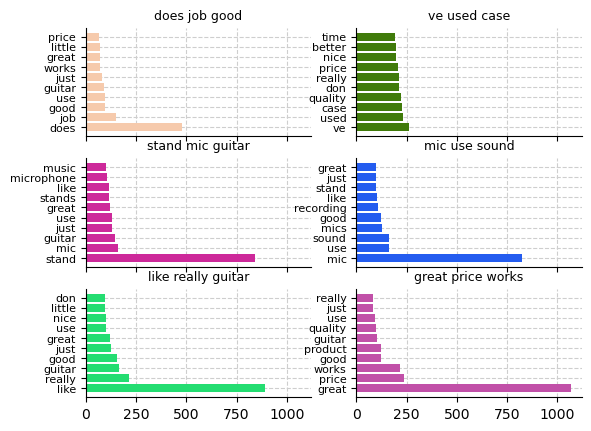

In [7]:
# Visualise first 6 clusters
cluster_range = 6

# rank top 10 words for each cluster in cluster range
def clusters_rank_words_by_tfidf(word_list, cluster_range):
    df_cluster_range1 = pd.DataFrame()
    for i in range(0,cluster_range):
        df_rev = df[df.Cluster == clusters[i]]
        indices = df_rev.index
    
        summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
        data = {'Word': word_list,
            'Summed TFIDF': summed_tfidf}
        #df_cluster_range.append(data)
        df_cluster_range = pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)
        df_cluster_range = df_cluster_range[:10] # top 10
        df_cluster_range['cluster'] = i
        df_cluster_range1 = pd.concat([df_cluster_range1,df_cluster_range])
    #df_cluster_range.to_frame()
    return df_cluster_range1
    #return pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)
    
test = clusters_rank_words_by_tfidf(words,cluster_range)

# graph these
df_to_use = test # top 10
six_bar_graph('Word','Summed TFIDF','Word','Score','Word scores')

# How can we tell what number of clusters to use?

We can use the elbow method of the MiniBatchMeans

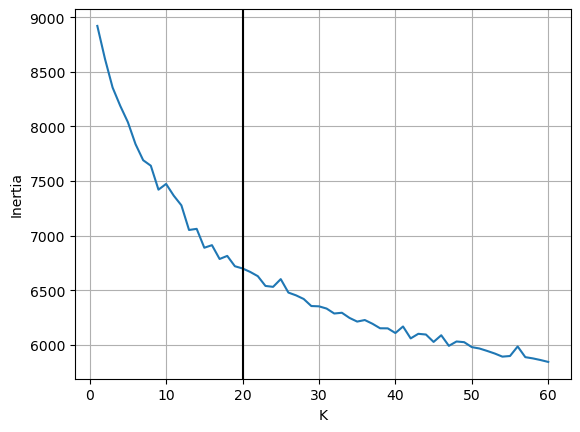

In [8]:
# but how to determine how many clusters to use? use minibatchkmeans
from sklearn.cluster import MiniBatchKMeans
# use the elbow method to find optimum K for cluster numbers

np.random.seed(0)
 
k_values = range(1, 61)
inertia_values = [MiniBatchKMeans(k, batch_size = 2048, n_init = 'auto').fit(shrunk_norm_matrix).inertia_
                  for k in k_values]
plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.axvline(cluster_number, c='k') # mark the number of clusters chosen
plt.grid(True)
plt.show()

Whilst 20 has been chosen above, from the graph it looks like 15 might be the better option. This is apporximately the point at which the elbow curve becomes shallower after 15 K.